In [1]:
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
import glob
import numpy as np
from scipy.linalg import toeplitz
from scipy.linalg import solve
from scipy.signal import lfilter
from scot.connectivity import Connectivity

import mne
from mne.io import concatenate_raws, read_raw_edf
import glob


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP, SPoC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from mne.decoding import (
    SlidingEstimator,
    GeneralizingEstimator,
    Scaler,
    cross_val_multiscore,
    LinearModel,
    get_coef,
    Vectorizer,
    CSP,
)
import numpy as np
from mne.preprocessing import ICA

from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from utils import preprocess_data

import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Flatten, BatchNormalization, Conv2D, DepthwiseConv2D, AveragePooling2D, Activation, SeparableConv2D, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
import glob
import numpy as np
from utils import preprocess_data
from mne.preprocessing import ICA

from __future__ import print_function

import numpy as np
try:  # new in sklearn 0.19
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
except ImportError:
    from sklearn.lda import LDA
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix


2023-09-07 00:41:18.720743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from mne_connectivity import spectral_connectivity_epochs

In [3]:

import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne_connectivity import spectral_connectivity_epochs

In [4]:
files = glob.glob('../../files/S001/*.edf')
'''
=========  ===================================
run        task
=========  ===================================
1          Baseline, eyes open
2          Baseline, eyes closed
3, 7, 11   Motor execution: left vs right hand
4, 8, 12   Motor imagery: left vs right hand
5, 9, 13   Motor execution: hands vs feet
6, 10, 14  Motor imagery: hands vs feet
=========  ===================================
'''
raws = []

for i in [5, 9, 13]:
    current_file = files[i]
    r = read_raw_edf(current_file, preload=True, stim_channel='auto')
    events, _ = mne.events_from_annotations(r)
    if i in [5, 9, 13]:
        new_labels_events = {1:'rest', 2:'action_hand', 3:'action_feet'} # action
    new_annot = mne.annotations_from_events(events=events, event_desc=new_labels_events, sfreq=r.info['sfreq'], orig_time=r.info['meas_date'])
    r.set_annotations(new_annot)
    raws.append(r)
    
raw_obj = concatenate_raws(raws)

Extracting EDF parameters from /Users/owalid/42/post_intership/total-perspective-vortex/files/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from /Users/owalid/42/post_intership/total-perspective-vortex/files/S001/S001R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from /Users/owalid/42/post_intership/total-perspective-vortex/files/S001/S001R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']


In [5]:
raw = raw_obj.copy()

# filters
notch_freq = 60
raw.notch_filter(notch_freq, fir_design='firwin')

low_cutoff = 8
high_cutoff = 40
raw.filter(low_cutoff, high_cutoff, fir_design='firwin')

events, event_dict = mne.events_from_annotations(raw)
print(raw.info)
print(event_dict)
picks = mne.pick_types(raw.info, meg=True, eeg=True, stim=False, eog=False, exclude='bads')
eegbci.standardize(raw)
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage)

## ICA
n_components = 10
ica = ICA(n_components=n_components, random_state=97, max_iter=800)
ica.fit(raw)
components_to_excludes, scores = ica.find_bads_eog(raw, ch_name='Fpz')
if components_to_excludes is not None and len(components_to_excludes) > 0:
    ica.exclude = components_to_excludes
    raw = ica.apply(raw)
else:
    print("No components to exclude")

event_id = {'action_hand': 1, 'action_feet': 2}
events, event_dict = mne.events_from_annotations(raw, event_id=event_id)
tmin = -0.5  # Time before event in seconds
tmax = 4.  # Time after event in seconds
epochs = mne.Epochs(raw, events, event_dict, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 sec)



Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 265 samples (1.656 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Used Annotations descriptions: ['action_feet', 'action_hand', 'rest']
<Info | 7 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 8.0 Hz
 lowpass: 40.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>
{'action_feet': 1, 'action_hand': 2, 'rest': 3}
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.8s.
Using EOG channel: Fpz
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


0 bad epochs dropped


In [6]:
times = epochs.times
ch_names = epochs.ch_names

In [11]:
import numpy as np

import mne
from mne import make_fixed_length_epochs

import matplotlib.pyplot as plt

from mne_connectivity import vector_auto_regression

In [12]:
conn = vector_auto_regression(
    data=epochs.get_data(), times=times, names=ch_names)

  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:00<00:00, 118.19it/s]


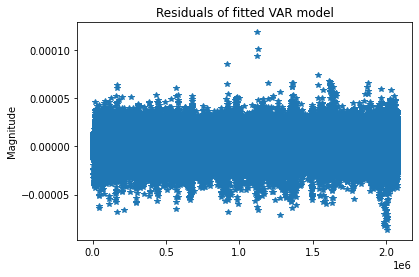

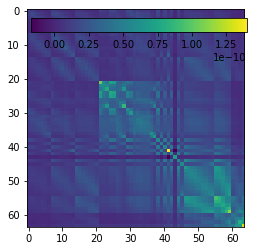

In [13]:
predicted_data = conn.predict(epochs.get_data())

# compute residuals
residuals = epochs.get_data() - predicted_data

# visualize the residuals
fig, ax = plt.subplots()
ax.plot(residuals.flatten(), '*')
ax.set(
    title='Residuals of fitted VAR model',
    ylabel='Magnitude'
)

# compute the covariance of the residuals
model_order = conn.attrs.get('model_order')
t = residuals.shape[0]
sampled_residuals = np.concatenate(
    np.split(residuals[:, :, model_order:], t, 0),
    axis=2
).squeeze(0)
rescov = np.cov(sampled_residuals)

# Next, we visualize the covariance of residuals.
# Here we will see that because we use ordinary
# least-squares as an estimation method, the residuals
# should come with low covariances.
fig, ax = plt.subplots()
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
im = ax.imshow(rescov, cmap='viridis', aspect='equal', interpolation='none')
fig.colorbar(im, cax=cax, orientation='horizontal')

In [14]:
conn = vector_auto_regression(
    data=epochs.get_data(), times=times, names=ch_names,
    model='avg-epochs')

# this returns a connectivity structure over time
print(conn)

<Connectivity | , nave : 45, nodes, n_estimated : 64, 4096, ~60 kB>


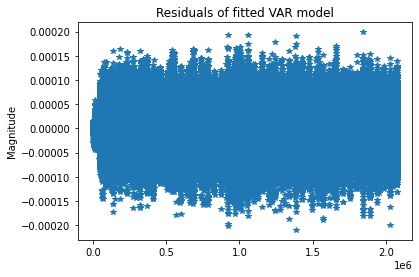

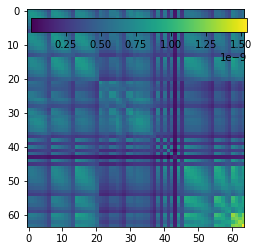

In [15]:
first_epoch = epochs.get_data()[0, ...]
predicted_data = conn.predict(first_epoch)

# compute residuals
residuals = epochs.get_data() - predicted_data

# visualize the residuals
fig, ax = plt.subplots()
ax.plot(residuals.flatten(), '*')
ax.set(
    title='Residuals of fitted VAR model',
    ylabel='Magnitude'
)

# compute the covariance of the residuals
model_order = conn.attrs.get('model_order')
t = residuals.shape[0]
sampled_residuals = np.concatenate(
    np.split(residuals[:, :, model_order:], t, 0),
    axis=2
).squeeze(0)
rescov = np.cov(sampled_residuals)

# Next, we visualize the covariance of residuals as before.
# Here we will see a similar trend with the covariances as
# with the covariances for time-varying VAR model.
fig, ax = plt.subplots()
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
im = ax.imshow(rescov, cmap='viridis', aspect='equal', interpolation='none')
fig.colorbar(im, cax=cax, orientation='horizontal')